# Subsampling LiDAR Point Clouds for STL Output

## Authors
Author1 = {"name": "Nathaniel Quinn", "affiliation": "UNAVCO, Inc.", "email": "nathaniel.quinn@unavco.org", "orcid":""}

## Purpose
Subsampling Voxel method for point cloud data thinning. 
Method to balance computation speeds with model accuracy.

After point cloud has been thinned, triangulation is computed to create a mesh. This mesh can be exported as a STL file and opened in a variety of 3D modeling software.

## Funding
OpenTopography is supported by the National Science Foundation under Award Numbers 1948997, 1948994 & 1948857

## Acknowledgments
This notebook is adapted from work by Florent Poux. For more details see his [medium blogpost](https://towardsdatascience.com/how-to-automate-lidar-point-cloud-processing-with-python-a027454a536c)

## Setup
Import libraries: NumPy,LasPy, Numpy-STL.  Note: We are using las files, which can be downloaded from OpenTopography.org for your specified region.

In [18]:
import numpy as np
import laspy as lp
from stl import mesh
import LidarSnapshot

## Data Processing
Load point cloud data file.

In [19]:
#lidar_file = "points.las"

port = "COM6"
camera = LidarSnapshot.setup(port)
point_cloud = []
if camera:
    try:
        point_cloud = LidarSnapshot.nextFrame(camera)
    except Exception as e:
        print(e)
    LidarSnapshot.cleanup(camera)
#point_cloud = lp.read(lidar_file)



ToF camera opened successfully:
    model:      4.0
    firmware:   3.3
    uid:        980165
    resolution: 160x60
    port:       COM6

Shutting down ...


Use LasPy library to get X,Y, and Z coordinates, then place them into NumPy arrays

In [20]:
#store coordinates in "points"
points = np.vstack((point_cloud[0], point_cloud[1], point_cloud[2])).transpose()
print("Number of points in original file:",len(points))

Number of points in original file: 343


**Grid Sampling of Point Cloud**

Using cubic cells called voxels, for each voxel, we use one representative point.  This point may be the barycenter of the points in the cell, or the point that is closest to the barycenter.

Change the "voxel_size" to vary subset resolution. Recommend somewhere between 5 and 15 for most OpenTopography datasets.

Note: voxel_size is in Meters

In [21]:
voxel_size=0.05
nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
print("The voxel grid is X,Y,Z voxels:", (nb_vox))

The voxel grid is X,Y,Z voxels: [4. 4. 5.]


Let's get a sense of how much the point cloud data will be reduced, both by point number and percentage of overall data subset into this new dataset.

NOTE: If the subset percentage is negative, increase your voxel size as your voxel is smaller than collected data resolution.

In [22]:
nb_vox_readout = np.prod(nb_vox, dtype=int) 
print("This will reduce number of points to", nb_vox_readout)

pts_length = len(points)
perct = ((1-(nb_vox_readout/pts_length))*100)
print("Or reduce by", perct, "%")

This will reduce number of points to 80
Or reduce by 76.67638483965014 %


**Define the function.**

Within this function, each voxel is tested to see if it contains one or more points.  Voxels that have points are kept in the set, and empty voxels are indexed. It then computes the point data that will be used to represent each individual voxel. 

Function credit: Florent Poux.  For more details see his [medium blogpost](https://towardsdatascience.com/how-to-automate-lidar-point-cloud-processing-with-python-a027454a536c)

In [23]:
#Define a function that takes as input an array of points, and a voxel size expressed in meters. It returns the sampled point cloud
def grid_subsampling(points, voxel_size):

  nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
  non_empty_voxel_keys, inverse, nb_pts_per_voxel= np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
  idx_pts_vox_sorted=np.argsort(inverse)
  voxel_grid={}
  grid_barycenter,grid_candidate_center=[],[]
  last_seen=0

  for idx,vox in enumerate(non_empty_voxel_keys):
    voxel_grid[tuple(vox)]=points[idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]]
    grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
    grid_candidate_center.append(voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)]-np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
    last_seen+=nb_pts_per_voxel[idx]

  return grid_candidate_center

Execute the function with the original point cloud data set and voxel size established previously.

In [24]:
grid_sampled_point_cloud = grid_subsampling(points, voxel_size)

Use numpy to convert list into an array for plotting.

In [25]:
grid_sample_pc_np = np.array(grid_sampled_point_cloud)

**Subsampled Point Cloud Plotting**

Plot just the points to get a sense of point density. Adjust voxel size depending on needs, balancing between accuracy, STL file size, and rendering speeds.

## Data Visualization

To view all points in subset dataset.

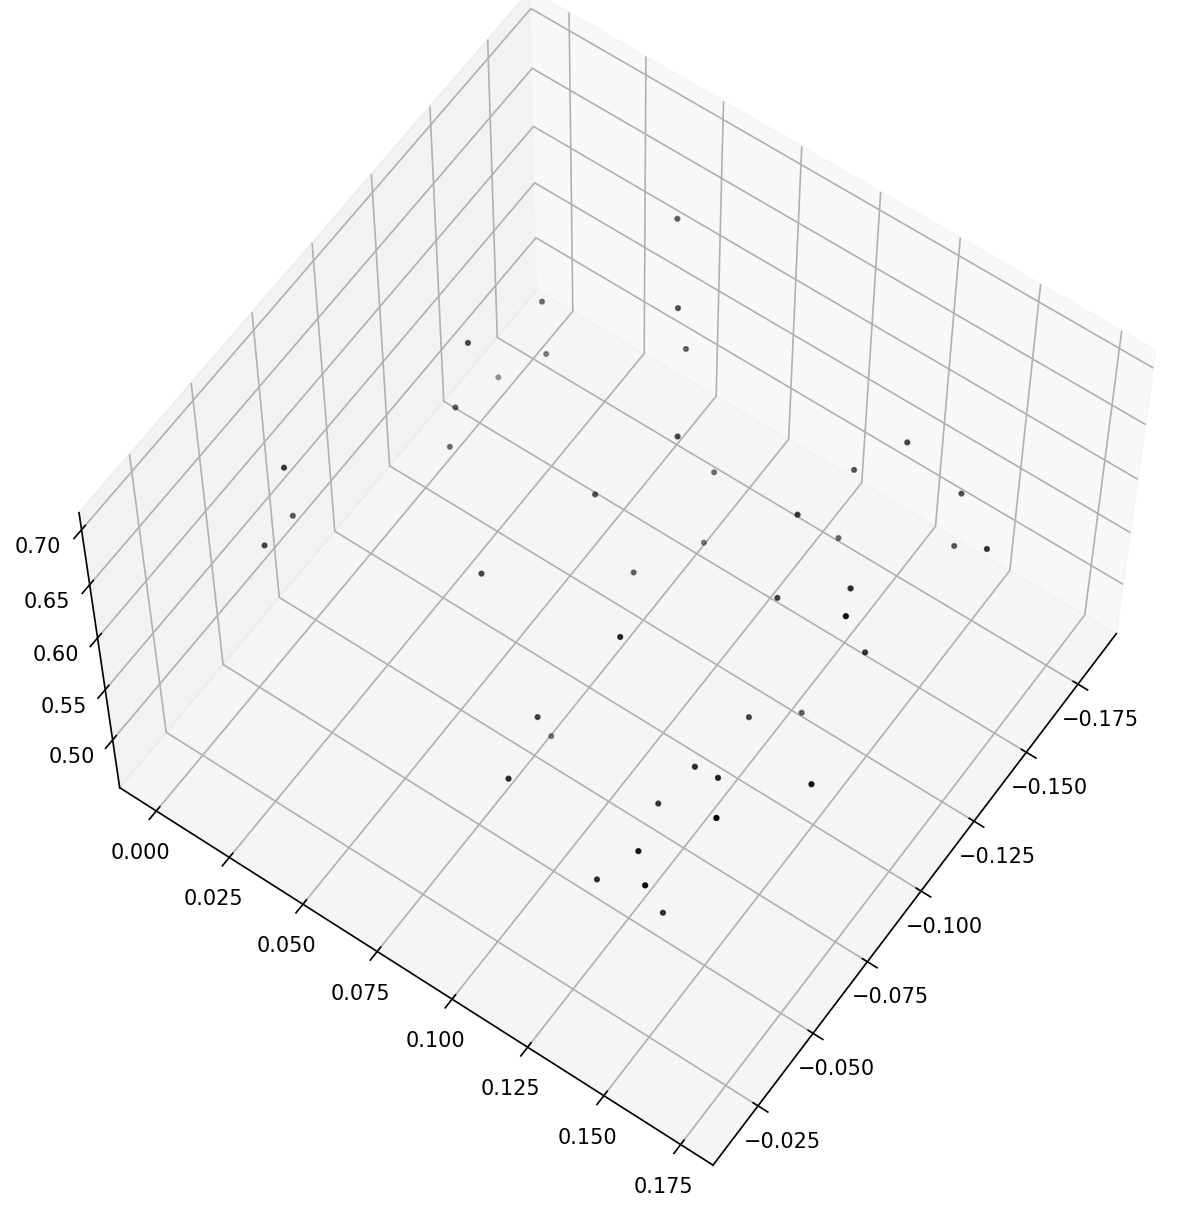

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from matplotlib.pyplot import figure
figure(figsize=(12, 10), dpi=150)

ax = plt.axes(projection='3d')
ax.scatter(grid_sample_pc_np[:,0], grid_sample_pc_np[:,1], grid_sample_pc_np[:,2], s = 4, c = 'black')
ax.view_init(60, 35)
plt.show()

**Triangulating for surface output**

Create a surface by triangulating between every 3 adjacent points.  This type of surfacing may be best for natural features.

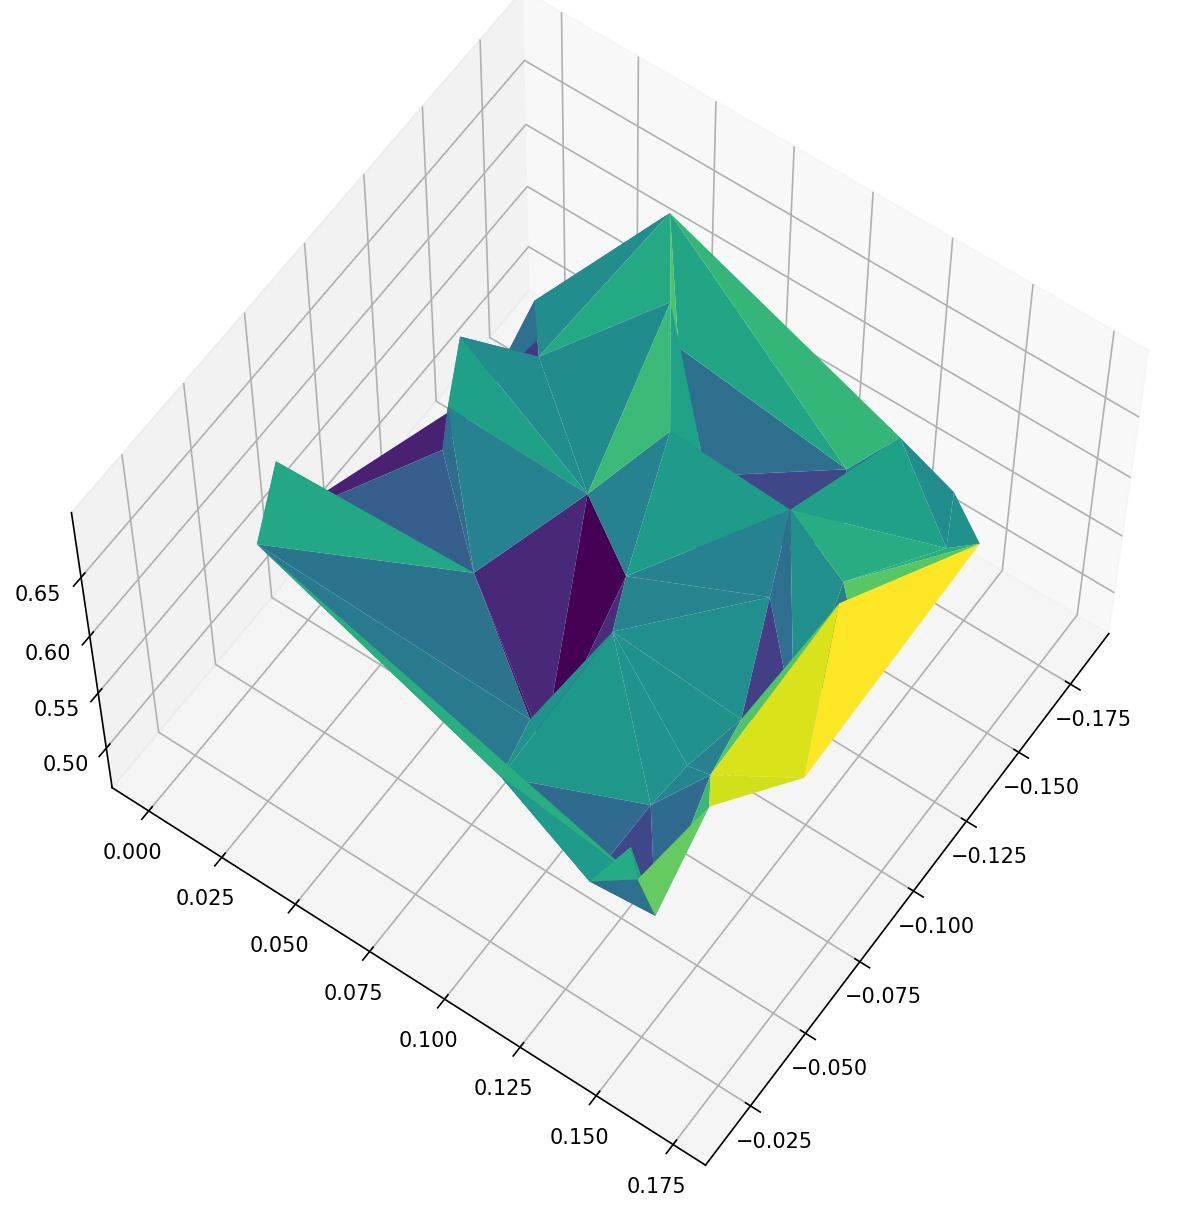

In [27]:
from matplotlib.pyplot import figure
figure(figsize=(12, 10), dpi=150)

ax = plt.axes(projection='3d')
trisurf = ax.plot_trisurf(grid_sample_pc_np[:,0], grid_sample_pc_np[:,1], grid_sample_pc_np[:,2], 
                ax.view_init(60, 35), cmap='viridis', edgecolor='none');

## Exporting

To export mesh as STL file. 

In [28]:
import numpy as np
import matplotlib.tri as mtri

x_all = grid_sample_pc_np[:,0]
y_all = grid_sample_pc_np[:,1]
z_all = grid_sample_pc_np[:,2]

tris = mtri.Triangulation(x_all, y_all)

data = np.zeros(len(tris.triangles), dtype=mesh.Mesh.dtype)
m = mesh.Mesh(data, remove_empty_areas=False)
m.x[:] = x_all[tris.triangles]
m.y[:] = y_all[tris.triangles]
m.z[:] = z_all[tris.triangles]

m.save('point_cloud_model3D_1.stl')